### HOUSE SALE PRICING PREDICTION

Here below you can see a detailed table of contents of the work:

**PREPROCESSING & EDA**

- Importing Libraries & Data
- Dealing with Duplicates and Nan
- Looking at correlations
- Data Normalization (Plots & Tests)


**MODELING**

- Baseline Models with 10-Folds CV
- Best Model (RandomGridSearch)
- Prediction
- Creating Submission to test predictions on leaderboard

In [ ]:
# IMPORTING LIBRARIES

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import skew, norm
from sklearn.neighbors import KNeighborsRegressor
%matplotlib inline

import warnings
warnings.filterwarnings(action="ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# IMPORTING DATA

house_data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
data_w = house_data.copy()
data_w.columns = data_w.columns.str.replace(' ', '') # Replacing the white spaces in columns' names
data_w.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [ ]:
data_w.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### EDA & VISUALIZATION

Before working with any kind of data it is important to understand them. A crucial step to this aim is the ***Exploratory data analysis (EDA)***: a combination of visualizations and statistical analysis (uni, bi, and multivariate) that helps us to better understand the data we are working with and to gain insight into their relationships. So, let's explore our target variable and how the other features influence it.

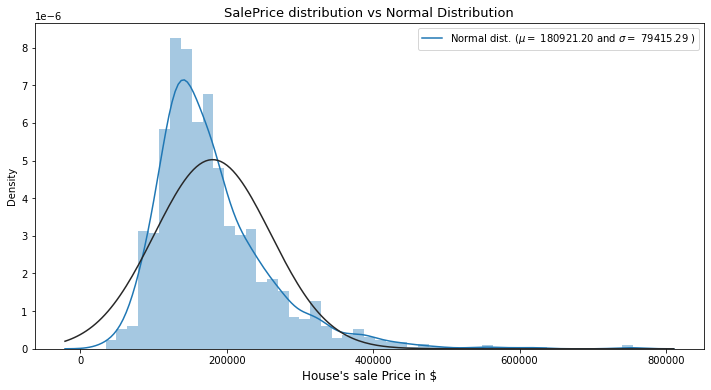

In [ ]:
# Getting the main parameters of the Normal Distribution ()
(mu, sigma) = norm.fit(data_w['SalePrice'])

plt.figure(figsize = (12,6))
sns.distplot(data_w['SalePrice'], kde = True, hist=True, fit = norm)
plt.title('SalePrice distribution vs Normal Distribution', fontsize = 13)
plt.xlabel("House's sale Price in $", fontsize = 12)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.show()

In literature, acceptable values for skewness are between -0.5 and 0.5 while -2 and 2 for Kurtosis. Looking at the plot, we can clearly see how the distribution does not seem to be normal, but highly right-skewed. The non-normality of our distribution is also supported by the Shapiro test for normality (p-value really small that allows us to reject the hypotesis of normality). Despite that, let's leave it like that for now, we'll deal with that later in the notebook. 

In [ ]:
# Checking the skewness and Kurtosis values of the SalesPrice column
from scipy import stats

shap_t,shap_p = stats.shapiro(data_w['SalePrice'])

print("Skewness: %f" % abs(data_w['SalePrice']).skew())
print("Kurtosis: %f" % abs(data_w['SalePrice']).kurt())
print("Shapiro_Test: %f" % shap_t)
print("Shapiro_Test: %f" % shap_p)

Skewness: 1.882876
Kurtosis: 6.536282
Shapiro_Test: 0.869672
Shapiro_Test: 0.000000


The correlation matrix is the best way to see all the numerical correlation between features. Let's see which are the feature that correlate most with our target variable.

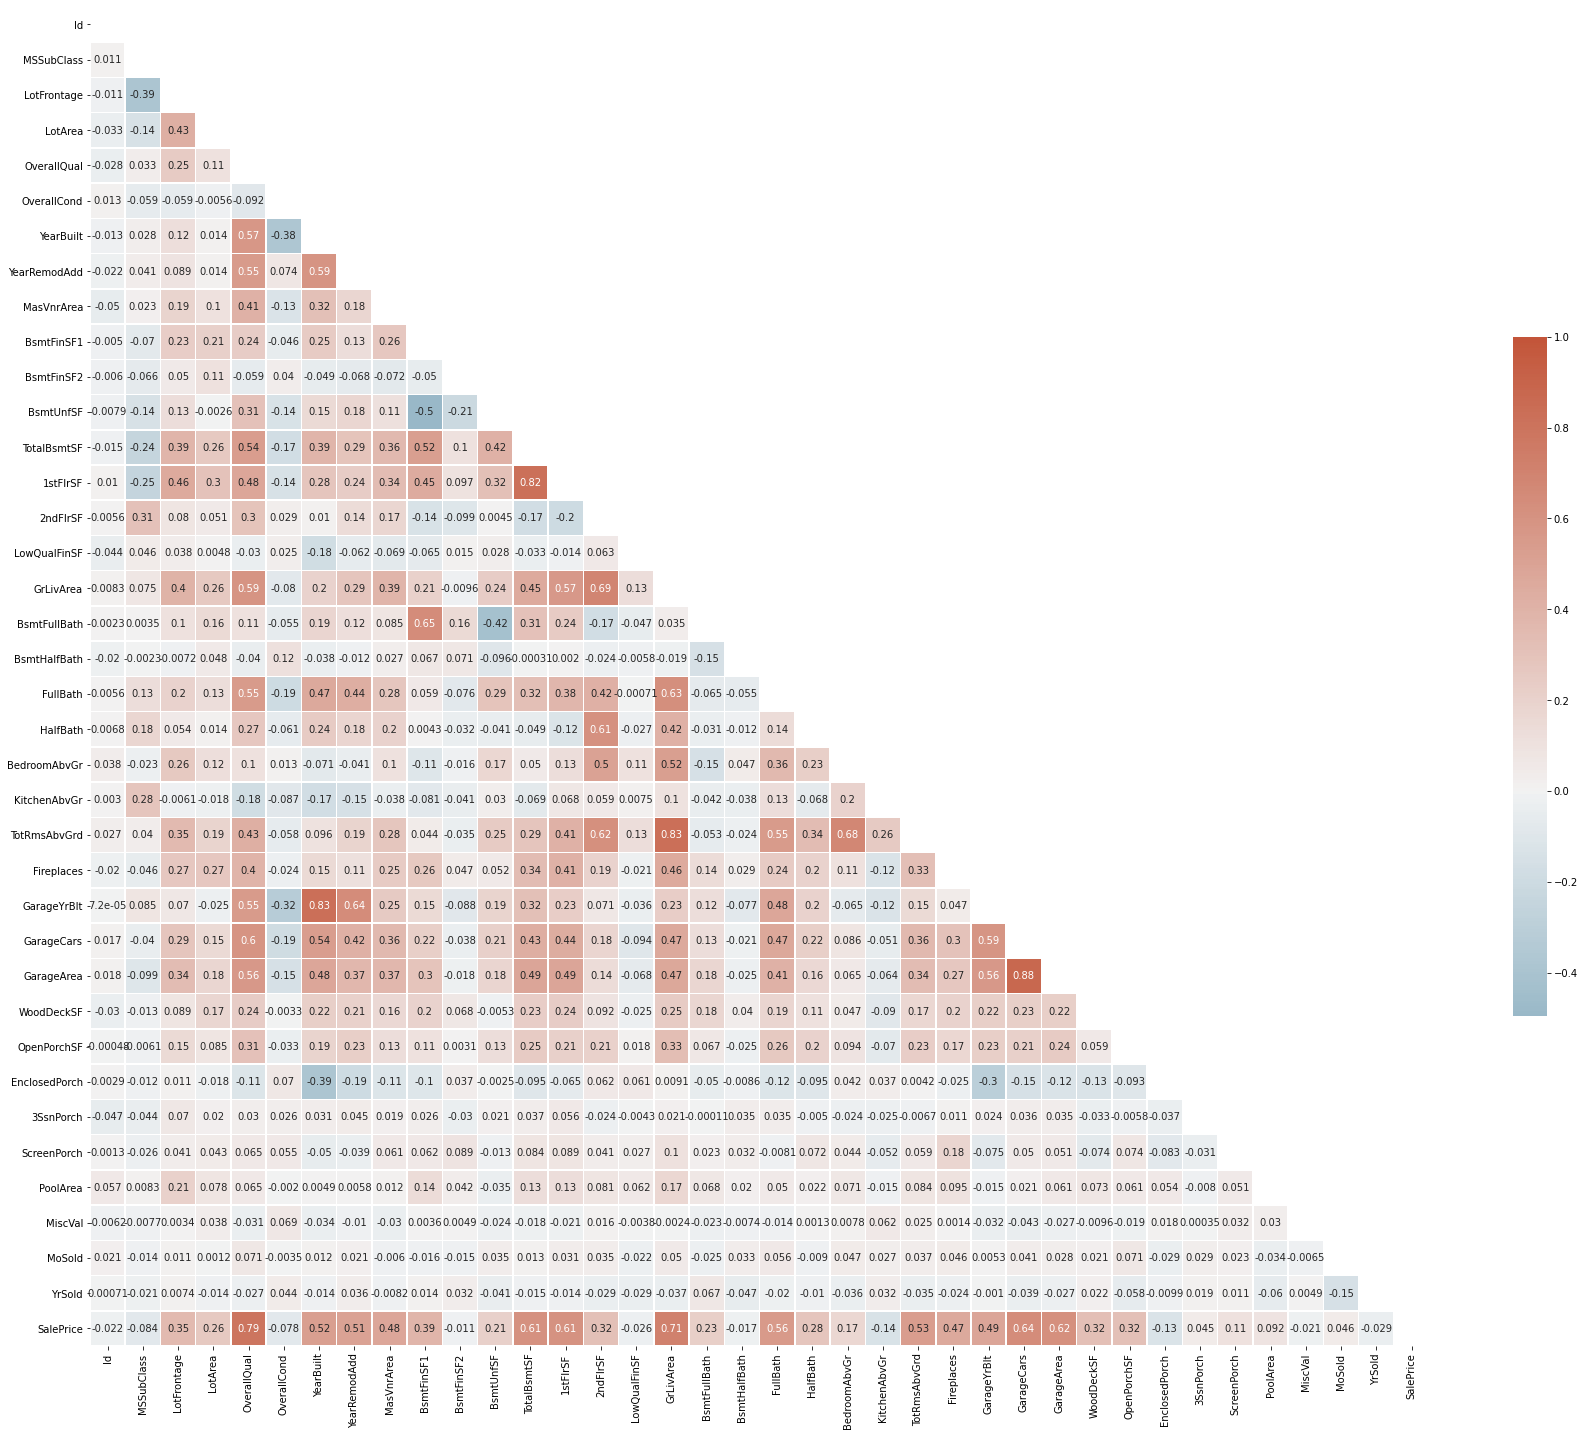

In [ ]:
# Correlation Matrix

f, ax = plt.subplots(figsize=(30, 25))
mat = data_w.corr('pearson')
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0, annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

Now that we know which features correlates most with our target variable we can investigate them more in depth.

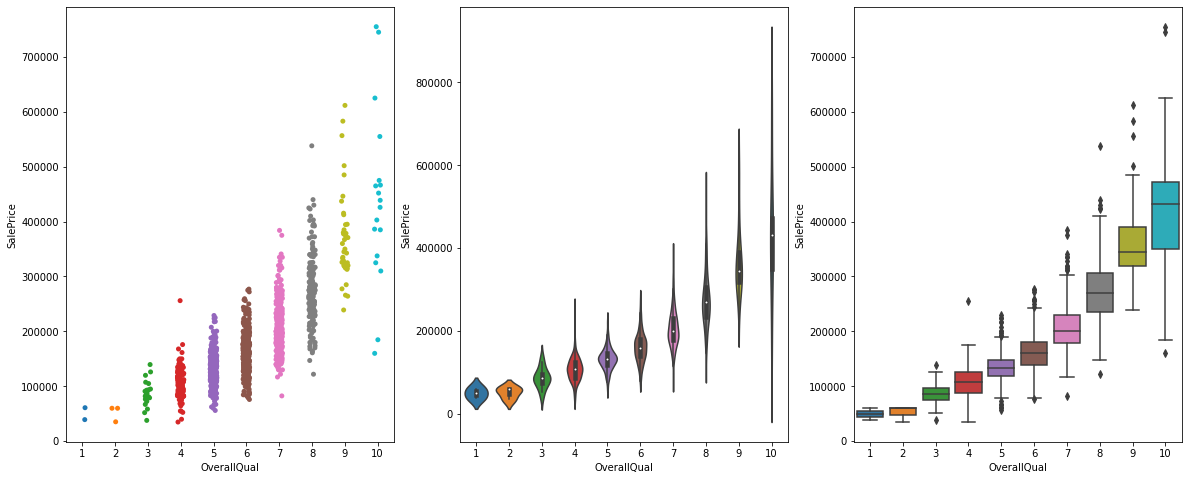

In [ ]:
# OverallQuall - SalePrice [Pearson = 0.8]

figure, ax = plt.subplots(1,3, figsize = (20,8))
sns.stripplot(data=data_w, x = 'OverallQual', y='SalePrice', ax = ax[0])## function to plot stripplot between "OverallQual" and "SalesPrice"
sns.violinplot(data=data_w, x = 'OverallQual', y='SalePrice', ax = ax[1])## function to plot violinplot between "OverallQual" and "SalesPrice"
sns.boxplot(data=data_w, x = 'OverallQual', y='SalePrice', ax = ax[2])## function to plot boxplot between "OverallQual" and "SalesPrice"
plt.show()

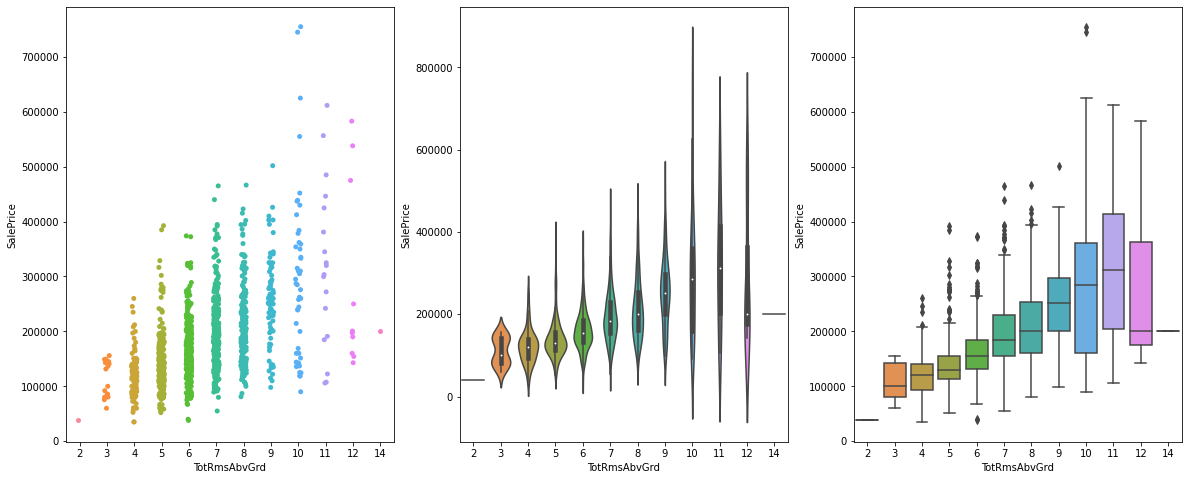

In [ ]:
# TotRmsAbvGrd - SalePrice [Pearson = 0.50]

figure, ax = plt.subplots(1,3, figsize = (20,8))
sns.stripplot(data=data_w, x = 'TotRmsAbvGrd', y='SalePrice', ax = ax[0])
sns.violinplot(data=data_w, x = 'TotRmsAbvGrd', y='SalePrice', ax = ax[1])
sns.boxplot(data=data_w, x = 'TotRmsAbvGrd', y='SalePrice', ax = ax[2])
plt.show()

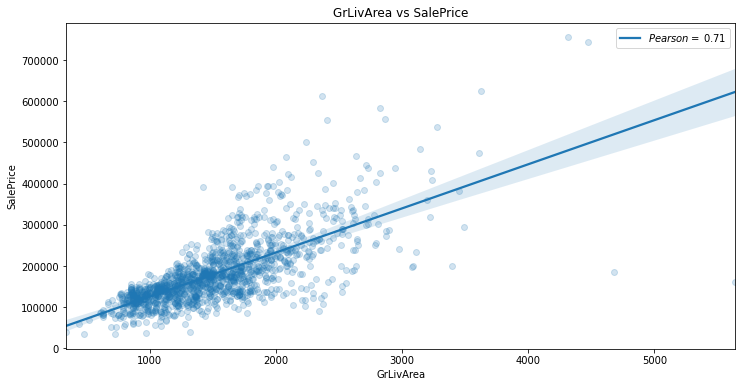

In [ ]:
# GrLivArea vs SalePrice [corr = 0.71]

Pearson_GrLiv = 0.71
plt.figure(figsize = (12,6))
sns.regplot(data=data_w, x = 'GrLivArea', y='SalePrice', scatter_kws={'alpha':0.2})## plotting regressionplot between the two features
plt.title('GrLivArea vs SalePrice', fontsize = 12)
plt.legend(['$Pearson=$ {:.2f}'.format(Pearson_GrLiv)], loc = 'best')
plt.show()

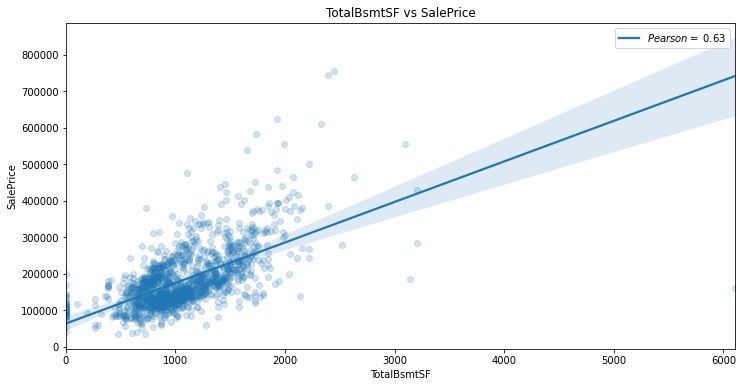

In [ ]:
Pearson_TBSF = 0.63
plt.figure(figsize = (12,6))
sns.regplot(data=data_w, x = 'TotalBsmtSF', y='SalePrice', scatter_kws={'alpha':0.2})
plt.title('TotalBsmtSF vs SalePrice', fontsize = 12)
plt.legend(['$Pearson=$ {:.2f}'.format(Pearson_TBSF)], loc = 'best')
plt.show()

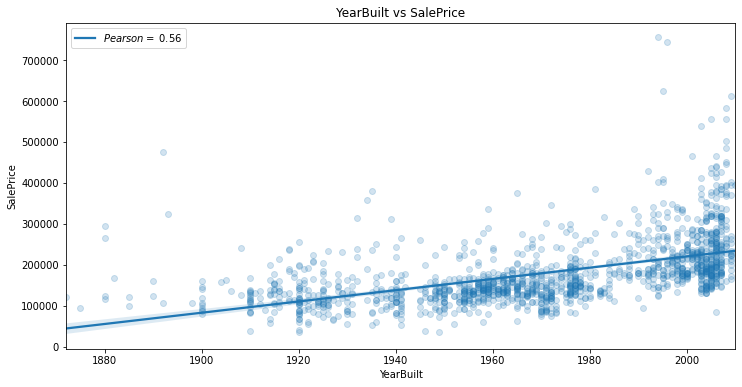

In [ ]:
# YearBuilt vs SalePrice

Pearson_YrBlt = 0.56
plt.figure(figsize = (12,6))
sns.regplot(data=data_w, x = 'YearBuilt', y='SalePrice', scatter_kws={'alpha':0.2})
plt.title('YearBuilt vs SalePrice', fontsize = 12)
plt.legend(['$Pearson=$ {:.2f}'.format(Pearson_YrBlt)], loc = 'best')
plt.show()

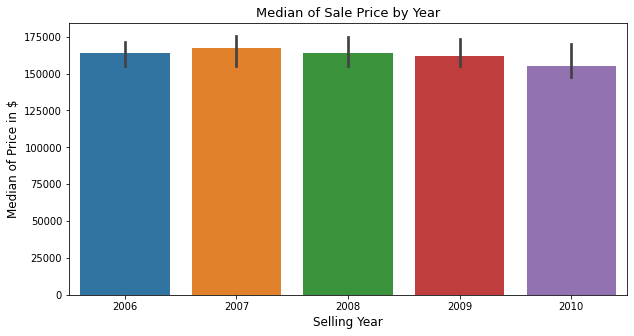

In [ ]:
# Median of Sale Price by Year

plt.figure(figsize = (10,5))
sns.barplot(x='YrSold', y="SalePrice", data = data_w, estimator = np.median)## plOtting barplot to check the year vs Salesprice distribution
plt.title('Median of Sale Price by Year', fontsize = 13)
plt.xlabel('Selling Year', fontsize = 12)
plt.ylabel('Median of Price in $', fontsize = 12)
plt.show()

###  DATA PREPROCESSING

Now that we have some insights about data, we need to preprocess them for the modeling part. The main steps are:

- Looking at potential NaN
- Dealing with categorical features (e.g. Dummy coding)
- Normalization

N.B:

Usually, in a real-world project, the test data are not available until the end. For this reason, test data should contain the same type of data of the training set to preprocess them in the same way. Here, the test set is available. It contains some observations not present in the training dataset and,the use of dummy coding could raise several issues (I spent a lot of time figuring out why I was not able to make predictions on the test set). The easiest way to solve this problem (that is not applicable if test data are not available) is to concatenate Train and Test sets, preprocess, and divide them again.


In [ ]:
# Separating Target and Features

target = data_w['SalePrice']
test_id = test['Id']
test = test.drop(['Id'],axis = 1)
data_w2 = data_w.drop(['SalePrice'], axis = 1)


# Concatenating train & test set

train_test = pd.concat([data_w2,test], axis=0, sort=False)

In [ ]:
# Looking at NaN % within the data

nan = pd.DataFrame(train_test.isna().sum(), columns = ['NaN_sum'])
nan['feat'] = nan.index
nan['Perc(%)'] = (nan['NaN_sum']/1460)*100
nan = nan[nan['NaN_sum'] > 0]
nan = nan.sort_values(by = ['NaN_sum'])
nan['Usability'] = np.where(nan['Perc(%)'] > 20, 'Discard', 'Keep')
nan

,NaN_sum,feat,Perc(%),Usability
TotalBsmtSF,1,TotalBsmtSF,0.068493,Keep
GarageArea,1,GarageArea,0.068493,Keep
GarageCars,1,GarageCars,0.068493,Keep
KitchenQual,1,KitchenQual,0.068493,Keep
Electrical,1,Electrical,0.068493,Keep
BsmtUnfSF,1,BsmtUnfSF,0.068493,Keep
BsmtFinSF2,1,BsmtFinSF2,0.068493,Keep
BsmtFinSF1,1,BsmtFinSF1,0.068493,Keep
SaleType,1,SaleType,0.068493,Keep
Exterior2nd,1,Exterior2nd,0.068493,Keep


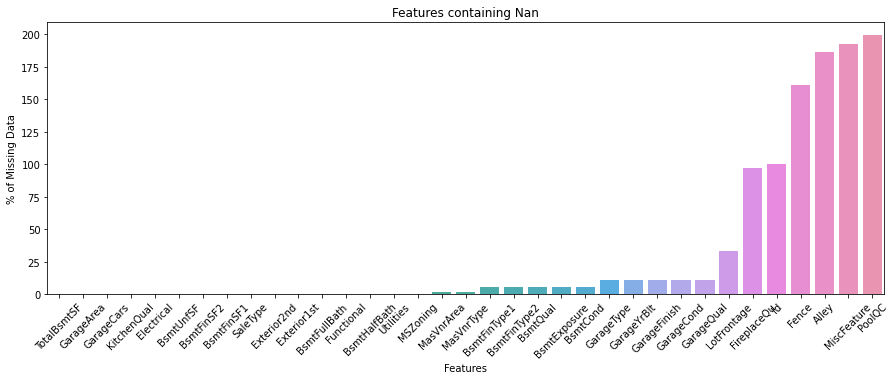

In [ ]:
# Plotting Nan

plt.figure(figsize = (15,5))
sns.barplot(x = nan['feat'], y = nan['Perc(%)'])
plt.xticks(rotation=45)
plt.title('Features containing Nan')
plt.xlabel('Features')
plt.ylabel('% of Missing Data')
plt.show()

Are we sure that all these nans are real missing values? Looking at the given description file, we can see how the majority of these nans reflect the absence of something, and for this reason, they are not nans. We can impute them (for numerical features) or substitute them with data in the file:

In [ ]:
# Converting non-numeric predictors stored as numbers into string

train_test['MSSubClass'] = train_test['MSSubClass'].apply(str)
train_test['YrSold'] = train_test['YrSold'].apply(str)
train_test['MoSold'] = train_test['MoSold'].apply(str)

# Filling Categorical NaN (That we know how to fill due to the description file )
## fillna means to fill the null values with value specified in the brackets

train_test['Functional'] = train_test['Functional'].fillna('Typ')
train_test['Electrical'] = train_test['Electrical'].fillna("SBrkr")
train_test['KitchenQual'] = train_test['KitchenQual'].fillna("TA")
train_test['Exterior1st'] = train_test['Exterior1st'].fillna(train_test['Exterior1st'].mode()[0])
train_test['Exterior2nd'] = train_test['Exterior2nd'].fillna(train_test['Exterior2nd'].mode()[0])
train_test['SaleType'] = train_test['SaleType'].fillna(train_test['SaleType'].mode()[0])
train_test["PoolQC"] = train_test["PoolQC"].fillna("None")
train_test["Alley"] = train_test["Alley"].fillna("None")
train_test['FireplaceQu'] = train_test['FireplaceQu'].fillna("None")
train_test['Fence'] = train_test['Fence'].fillna("None")
train_test['MiscFeature'] = train_test['MiscFeature'].fillna("None")

for col in ('GarageArea', 'GarageCars'):
    train_test[col] = train_test[col].fillna(0)
        
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    train_test[col] = train_test[col].fillna('None')
    
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    train_test[col] = train_test[col].fillna('None')
    
    # Checking the features with NaN remained out

for col in train_test:
    if train_test[col].isna().sum() > 0:
        print(train_test[col][0])

0    1.0
0    NaN
Name: Id, dtype: float64
0    RL
0    RH
Name: MSZoning, dtype: object
0    65.0
0    80.0
Name: LotFrontage, dtype: float64
0    AllPub
0    AllPub
Name: Utilities, dtype: object
0    BrkFace
0       None
Name: MasVnrType, dtype: object
0    196.0
0      0.0
Name: MasVnrArea, dtype: float64
0    706.0
0    468.0
Name: BsmtFinSF1, dtype: float64
0      0.0
0    144.0
Name: BsmtFinSF2, dtype: float64
0    150.0
0    270.0
Name: BsmtUnfSF, dtype: float64
0    856.0
0    882.0
Name: TotalBsmtSF, dtype: float64
0    1.0
0    0.0
Name: BsmtFullBath, dtype: float64
0    0.0
0    0.0
Name: BsmtHalfBath, dtype: float64
0    2003.0
0    1961.0
Name: GarageYrBlt, dtype: float64


In [ ]:
# Removing the useless variables

useless = ['GarageYrBlt','YearRemodAdd'] 
train_test = train_test.drop(useless, axis = 1)

# Imputing with KnnRegressor (we can also use different Imputers)

def impute_knn(df):
    ttn = train_test.select_dtypes(include=[np.number])## selecting the datatype which is numerical
    ttc = train_test.select_dtypes(exclude=[np.number])

    cols_nan = ttn.columns[ttn.isna().any()].tolist()         # columns w/ nan 
    cols_no_nan = ttn.columns.difference(cols_nan).values     # columns w/n nan

    for col in cols_nan:
        imp_test = ttn[ttn[col].isna()]   # indicies which have missing data will become our test set
        imp_train = ttn.dropna()          # all indicies which which have no missing data 
        model = KNeighborsRegressor(n_neighbors=5)  # KNR Unsupervised Approach
        knr = model.fit(imp_train[cols_no_nan], imp_train[col])
        ttn.loc[ttn[col].isna(), col] = knr.predict(imp_test[cols_no_nan])
    
    return pd.concat([ttn,ttc],axis=1)

train_test = impute_knn(train_test)


objects = []
for i in train_test.columns:
    if train_test[i].dtype == object:
        objects.append(i)
train_test.update(train_test[objects].fillna('None'))

# # Checking NaN presence

for col in train_test:
    if train_test[col].isna().sum() > 0:
        print(train_test[col][0])

### FEATURE ENGINEERING

Let's create some new features combining the ones that we already have. These could help us to increase the performance of the model!

In [ ]:
train_test["SqFtPerRoom"] = train_test["GrLivArea"] / (train_test["TotRmsAbvGrd"] +
                                                       train_test["FullBath"] +
                                                       train_test["HalfBath"] +
                                                       train_test["KitchenAbvGr"])

train_test['Total_Home_Quality'] = train_test['OverallQual'] + train_test['OverallCond']

train_test['Total_Bathrooms'] = (train_test['FullBath'] + (0.5 * train_test['HalfBath']) +
                               train_test['BsmtFullBath'] + (0.5 * train_test['BsmtHalfBath']))

train_test["HighQualSF"] = train_test["1stFlrSF"] + train_test["2ndFlrSF"]

# Converting non-numeric predictors stored as numbers into string

train_test['MSSubClass'] = train_test['MSSubClass'].apply(str)
train_test['YrSold'] = train_test['YrSold'].apply(str)
train_test['MoSold'] = train_test['MoSold'].apply(str)

# Creating dummy variables from categorical features

train_test_dummy = pd.get_dummies(train_test)

# Fetch all numeric features

#train_test['Id'] = train_test['Id'].apply(str)
numeric_features = train_test_dummy.dtypes[train_test_dummy.dtypes != object].index
skewed_features = train_test_dummy[numeric_features].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skewed_features[skewed_features > 0.5]
skew_index = high_skew.index

# Normalize skewed features using log_transformation
    
for i in skew_index:
    train_test_dummy[i] = np.log1p(train_test_dummy[i])

Now let's try to tranform our target distribution into a normal one. To do this we use a log transformation. We will use qq-plot to see the transformation effect.  

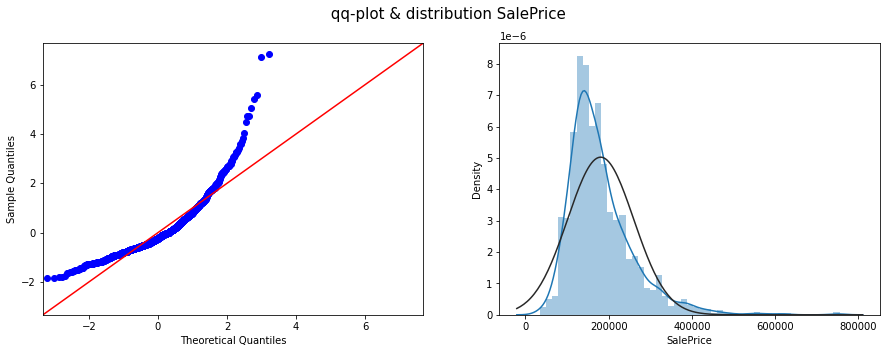

In [ ]:
# SalePrice before transformation

fig, ax = plt.subplots(1,2, figsize= (15,5))
fig.suptitle(" qq-plot & distribution SalePrice ", fontsize= 15)

sm.qqplot(target, stats.t, distargs=(4,),fit=True, line="45", ax = ax[0])

sns.distplot(target, kde = True, hist=True, fit = norm, ax = ax[1])
plt.show()

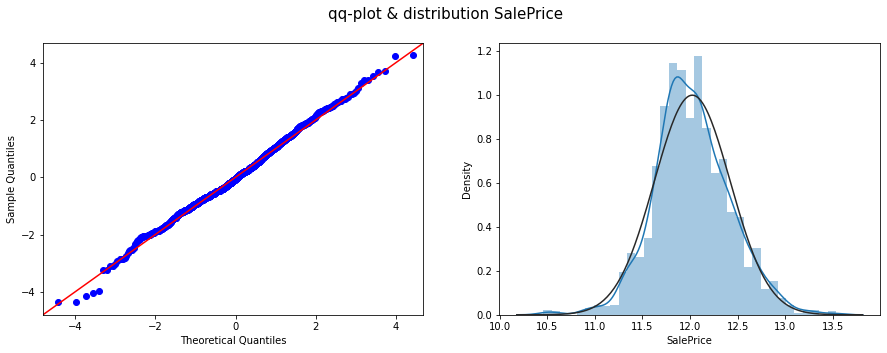

In [ ]:
# SalePrice after transformation

target_log = np.log1p(target)

fig, ax = plt.subplots(1,2, figsize= (15,5))
fig.suptitle("qq-plot & distribution SalePrice ", fontsize= 15)

sm.qqplot(target_log, stats.t, distargs=(4,),fit=True, line="45", ax = ax[0])
sns.distplot(target_log, kde = True, hist=True, fit = norm, ax = ax[1])
plt.show()

### MODELING

In [ ]:
!pip install shap -q
!pip install catboost -q

     |████████████████████████████████| 358kB 7.8MB/s 
     |████████████████████████████████| 69.2MB 62kB/s 


In [ ]:
import shap
import xgboost as xgb
from catboost import Pool
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor
from mlxtend.regressor import StackingRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error

In [ ]:
# Train-Test separation

train = train_test_dummy[0:1460]
test = train_test_dummy[1460:]
test['Id'] = test_id

# Creation of the RMSE metric:
    
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model):
    rmse = np.sqrt(-cross_val_score(model, train, target_log, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

In [ ]:
# 5 Fold Cross validation

kf = KFold(n_splits=5, random_state=42, shuffle=True)

cv_scores = []
cv_std = []

baseline_models = ['Linear_Reg.','Bayesian_Ridge_Reg.','LGBM_Reg.','SVR',
                   'Dec_Tree_Reg.','Random_Forest_Reg.', 'XGB_Reg.',
                   'Grad_Boost_Reg.','Cat_Boost_Reg.','Stacked_Reg.']

# Linear Regression

lreg = LinearRegression()# creating LR model
score_lreg = cv_rmse(lreg)# getting cross validation RMSE score of linear Regressor model
cv_scores.append(score_lreg.mean()) # append the mean of scores to the list of model for further plottinng and analysis
cv_std.append(score_lreg.std())# append the standard deviation of scores to the list of model for further plottinng and analysis

# Bayesian Ridge Regression

brr = BayesianRidge(compute_score=True)
score_brr = cv_rmse(brr)
cv_scores.append(score_brr.mean())
cv_std.append(score_brr.std())

# Light Gradient Boost Regressor

l_gbm = LGBMRegressor(objective='regression')
score_l_gbm = cv_rmse(l_gbm)
cv_scores.append(score_l_gbm.mean())
cv_std.append(score_l_gbm.std())

# Support Vector Regression

svr = SVR()
score_svr = cv_rmse(svr)
cv_scores.append(score_svr.mean())
cv_std.append(score_svr.std())

# Decision Tree Regressor

dtr = DecisionTreeRegressor()
score_dtr = cv_rmse(dtr)
cv_scores.append(score_dtr.mean())
cv_std.append(score_dtr.std())

# Random Forest Regressor

rfr = RandomForestRegressor()
score_rfr = cv_rmse(rfr)
cv_scores.append(score_rfr.mean())
cv_std.append(score_rfr.std())

# XGB Regressor

xgb = xgb.XGBRegressor()
score_xgb = cv_rmse(xgb)
cv_scores.append(score_xgb.mean())
cv_std.append(score_xgb.std())

# Gradient Boost Regressor

gbr = GradientBoostingRegressor()
score_gbr = cv_rmse(gbr)
cv_scores.append(score_gbr.mean())
cv_std.append(score_gbr.std())

# Cat Boost Regressor

catb = CatBoostRegressor()
score_catb = cv_rmse(catb)
cv_scores.append(score_catb.mean())
cv_std.append(score_catb.std())

# Stacked Regressor

stack_gen = StackingRegressor(regressors=(CatBoostRegressor(),
                                          LinearRegression(),
                                          BayesianRidge(),
                                          GradientBoostingRegressor()),
                              meta_regressor = CatBoostRegressor(),
                              use_features_in_secondary = True)

score_stack_gen = cv_rmse(stack_gen)
cv_scores.append(score_stack_gen.mean())
cv_std.append(score_stack_gen.std())

final_cv_score = pd.DataFrame(baseline_models, columns = ['Regressors'])
final_cv_score['RMSE_mean'] = cv_scores
final_cv_score['RMSE_std'] = cv_std

Streaming output truncated to the last 5000 lines.
4:	learn: 0.3481397	total: 36.7ms	remaining: 7.3s
5:	learn: 0.3373573	total: 44.1ms	remaining: 7.31s
6:	learn: 0.3275092	total: 58.9ms	remaining: 8.35s
7:	learn: 0.3177443	total: 69.1ms	remaining: 8.56s
8:	learn: 0.3083351	total: 76.3ms	remaining: 8.4s
9:	learn: 0.2994997	total: 83.6ms	remaining: 8.27s
10:	learn: 0.2905824	total: 91ms	remaining: 8.18s
11:	learn: 0.2820757	total: 98.2ms	remaining: 8.08s
12:	learn: 0.2739968	total: 105ms	remaining: 8s
13:	learn: 0.2656933	total: 113ms	remaining: 7.93s
14:	learn: 0.2575702	total: 120ms	remaining: 7.87s
15:	learn: 0.2502372	total: 127ms	remaining: 7.81s
16:	learn: 0.2428839	total: 134ms	remaining: 7.77s
17:	learn: 0.2365694	total: 142ms	remaining: 7.73s
18:	learn: 0.2296330	total: 149ms	remaining: 7.68s
19:	learn: 0.2230184	total: 156ms	remaining: 7.64s
20:	learn: 0.2165821	total: 163ms	remaining: 7.61s
21:	learn: 0.2106265	total: 171ms	remaining: 7.58s
22:	learn: 0.2051174	total: 182ms	re

In [ ]:
final_cv_score

,Regressors,RMSE_mean,RMSE_std
0,Linear_Reg.,0.142613,0.016785
1,Bayesian_Ridge_Reg.,0.130985,0.019756
2,LGBM_Reg.,0.136391,0.016749
3,SVR,0.281008,0.018802
4,Dec_Tree_Reg.,0.208202,0.012261
5,Random_Forest_Reg.,0.145108,0.017619
6,XGB_Reg.,0.137770,0.014574
7,Grad_Boost_Reg.,0.135789,0.020804
8,Cat_Boost_Reg.,0.124615,0.017344
9,Stacked_Reg.,0.122075,0.017445


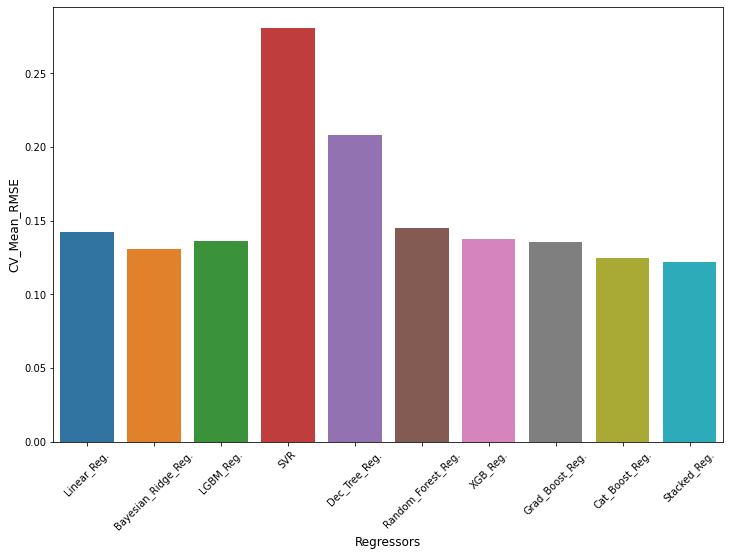

In [ ]:
plt.figure(figsize = (12,8))
sns.barplot(final_cv_score['Regressors'],final_cv_score['RMSE_mean'])
plt.xlabel('Regressors', fontsize = 12)
plt.ylabel('CV_Mean_RMSE', fontsize = 12)
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Train-Test split the data

X_train,X_val,y_train,y_val = train_test_split(train,target_log,test_size = 0.1,random_state=42)

# Cat Boost Regressor

cat = CatBoostRegressor()# creating catboostregressor model
cat_model = cat.fit(X_train,y_train,
                     eval_set = (X_val,y_val),
                     plot=True,
                     verbose = 0)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
cat_pred = cat_model.predict(X_val)
cat_score = rmse(y_val, cat_pred)
cat_score

0.11425033981873343

Now let's take a look at the top 20 most important variables for our model. This could give us further insight into the functioning of the algorithm and how and which data it uses most to arrive at the final prediction.

In [ ]:
# getting Features' importance of our catboost model

feat_imp = cat_model.get_feature_importance(prettified=True)
feat_imp

,Feature Id,Importances
0,OverallQual,16.722386
1,HighQualSF,9.051193
2,TotalBsmtSF,6.842070
3,Total_Home_Quality,5.364141
4,GrLivArea,4.845570
...,...,...
332,Fence_MnWw,0.000000
333,MiscFeature_None,0.000000
334,MiscFeature_TenC,0.000000
335,SaleType_Con,0.000000


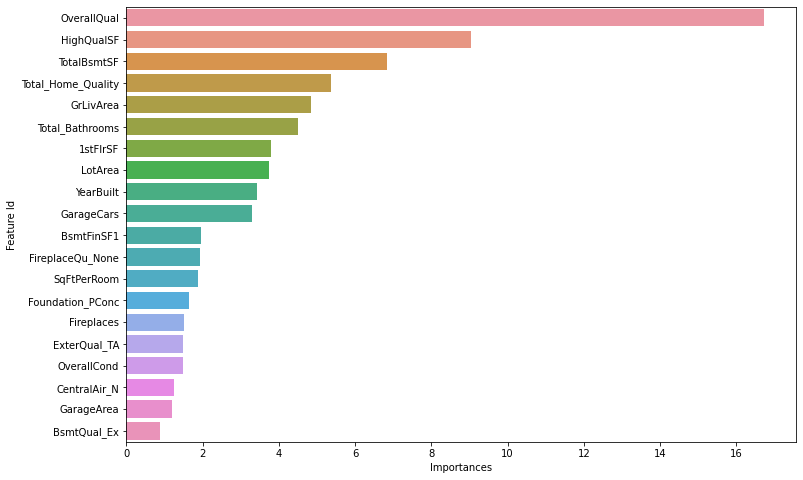

In [ ]:
# Plotting top 20 features' importance

plt.figure(figsize = (12,8))
sns.barplot(feat_imp['Importances'][:20],feat_imp['Feature Id'][:20], orient = 'h')
plt.show()

 N.B: Catboost comes with a great method: ***get_feature_importance***. This method can be used to find important interactions among features. This is a huge advantage because it can give us insights about possible new features to create that can improve the performance.  

In [ ]:
# Features' Interactions

train_data = Pool(X_train)

interaction = cat_model.get_feature_importance(train_data, type="Interaction")
column_names = X_train.columns.values 
interaction = pd.DataFrame(interaction, columns=["feature1", "feature2", "importance"])
interaction.feature1 = interaction.feature1.apply(lambda l: column_names[int(l)])
interaction.feature2 = interaction.feature2.apply(lambda l: column_names[int(l)])
interaction.head(20)

,feature1,feature2,importance
0,OverallQual,HighQualSF,0.635772
1,OverallQual,1stFlrSF,0.591284
2,LotArea,HighQualSF,0.587221
3,LotArea,YearBuilt,0.533889
4,LotArea,OverallQual,0.505388
5,TotalBsmtSF,HighQualSF,0.465063
6,OverallQual,YearBuilt,0.391649
7,1stFlrSF,MoSold_12,0.367174
8,BsmtFinSF1,HighQualSF,0.340211
9,OverallQual,GarageArea,0.334226


Which are the deafult parameters used by CaboostRegressor? This is our real baseline, now we need to optimize the hyperparameters trying to tune the model to obtain a better performance.

In [ ]:
# Catboost default paramters

cat_model.get_all_params()

{'auto_class_weights': 'None',
 'bayesian_matrix_reg': 0.10000000149011612,
 'best_model_min_trees': 1,
 'boost_from_average': True,
 'boosting_type': 'Plain',
 'bootstrap_type': 'MVS',
 'border_count': 254,
 'classes_count': 0,
 'depth': 6,
 'eval_metric': 'RMSE',
 'feature_border_type': 'GreedyLogSum',
 'grow_policy': 'SymmetricTree',
 'iterations': 1000,
 'l2_leaf_reg': 3,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'leaf_estimation_iterations': 1,
 'leaf_estimation_method': 'Newton',
 'learning_rate': 0.048517998307943344,
 'loss_function': 'RMSE',
 'max_leaves': 64,
 'min_data_in_leaf': 1,
 'model_shrink_mode': 'Constant',
 'model_shrink_rate': 0,
 'model_size_reg': 0.5,
 'nan_mode': 'Min',
 'penalties_coefficient': 1,
 'pool_metainfo_options': {'tags': {}},
 'posterior_sampling': False,
 'random_seed': 0,
 'random_strength': 1,
 'rsm': 1,
 'sampling_frequency': 'PerTree',
 'score_function': 'Cosine',
 'sparse_features_conflict_fraction': 0,
 'subsample': 0.800000011920929

### Hyperparameter Optimization

In [ ]:
# Preforming a Random Grid Search to find the best combination of parameters

grid = {'iterations': [1000,6000],
        'learning_rate': [0.05, 0.005, 0.0005],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 9]}

final_model = CatBoostRegressor()
randomized_search_result = final_model.randomized_search(grid,
                                                   X = X_train,
                                                   y= y_train,
                                                   verbose = False,
                                                   plot=True)
                                                   

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Streaming output truncated to the last 5000 lines.
1000:	learn: 0.1738091	test: 0.1995492	best: 0.1995492 (1000)
1001:	learn: 0.1734963	test: 0.1992481	best: 0.1992481 (1001)
1002:	learn: 0.1732033	test: 0.1989567	best: 0.1989567 (1002)
1003:	learn: 0.1728981	test: 0.1986652	best: 0.1986652 (1003)
1004:	learn: 0.1726033	test: 0.1983844	best: 0.1983844 (1004)
1005:	learn: 0.1723125	test: 0.1981104	best: 0.1981104 (1005)
1006:	learn: 0.1720184	test: 0.1978309	best: 0.1978309 (1006)
1007:	learn: 0.1717413	test: 0.1975520	best: 0.1975520 (1007)
1008:	learn: 0.1714370	test: 0.1972669	best: 0.1972669 (1008)
1009:	learn: 0.1711480	test: 0.1970034	best: 0.1970034 (1009)
1010:	learn: 0.1708644	test: 0.1967522	best: 0.1967522 (1010)
1011:	learn: 0.1705985	test: 0.1964955	best: 0.1964955 (1011)
1012:	learn: 0.1703291	test: 0.1962305	best: 0.1962305 (1012)
1013:	learn: 0.1700391	test: 0.1959810	best: 0.1959810 (1013)
1014:	learn: 0.1697560	test: 0.1957197	best: 0.1957197 (1014)
1015:	learn: 0.1694

In [ ]:
# Final Cat-Boost Regressor

params = {'iterations': 6000,
          'learning_rate': 0.005,
          'depth': 4,
          'l2_leaf_reg': 1,
          'eval_metric':'RMSE',
          'early_stopping_rounds': 200,
          'verbose': 200,
          'random_seed': 42}
         
cat_f = CatBoostRegressor(**params)
cat_model_f = cat_f.fit(X_train,y_train,
                     eval_set = (X_val,y_val),
                     plot=True,
                     verbose = False)

catf_pred = cat_model_f.predict(X_val)
catf_score = rmse(y_val, catf_pred)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
catf_score

0.10982180331705935

### MAKING A FINAL SUBMISSION FILE

In [ ]:
# Test CSV Submission

test_pred = cat_f.predict(test)
submission = pd.DataFrame(test_id, columns = ['Id'])
test_pred = np.expm1(test_pred)
submission['SalePrice'] = test_pred 
submission.head()

,Id,SalePrice
0,1461,126607.405075
1,1462,155075.895784
2,1463,183852.257174
3,1464,192325.456984
4,1465,184613.427374


In [ ]:
# Saving the results in a csv file

submission.to_csv("result.csv", index = False, header = True)

After Submitting the submission file on the Kaggle Competetion Platform, we found out that our predictions stood amongst top **0.3%** of participants with a RMSE score of 0.0553

## Comparing our predictions with original prices

In [ ]:
X_val.head()

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SqFtPerRoom,Total_Home_Quality,Total_Bathrooms,HighQualSF,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,...,Fence_MnPrv,Fence_MnWw,Fence_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MoSold_1,MoSold_10,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
892,893.0,4.262680,9.037771,6,2.197225,1963,0.000000,6.498282,0.0,5.983936,6.966024,6.974479,0.000000,0.0,6.974479,0.000000,0.693147,1,0.000000,3,0.693147,1.945910,0.000000,1.0,264.0,5.262690,0.000000,0.000000,0.0,0.0,0.0,0.0,4.901564,14,1.5,6.974479,0.0,0.0,0.0,0.0,...,0.693359,0.0,0,0.0,1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.693359,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.693359,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,1,0.0
1105,1106.0,4.595120,9.413852,8,1.791759,1994,5.894403,6.940222,0.0,6.068426,7.288928,7.313887,7.023759,0.0,7.872074,0.693147,0.000000,2,0.693147,3,0.693147,2.302585,1.098612,2.0,712.0,5.231109,3.496508,0.000000,0.0,0.0,0.0,0.0,5.311689,13,3.5,7.872074,0.0,0.0,0.0,0.0,...,0.000000,0.0,1,0.0,1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.693359,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.693359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,1,0.0
413,414.0,4.043051,9.100637,5,1.945910,1927,0.000000,0.000000,0.0,6.916715,6.916715,6.936343,0.000000,0.0,6.936343,0.000000,0.000000,1,0.000000,2,0.693147,1.791759,0.693147,2.0,360.0,0.000000,0.000000,4.875197,0.0,0.0,0.0,0.0,4.996247,11,1.0,6.936343,0.0,0.0,0.0,0.0,...,0.000000,0.0,1,0.0,1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.693359,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.693359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,1,0.0
522,523.0,3.931826,8.517393,6,2.079442,1947,0.000000,5.991465,0.0,6.406880,6.912743,6.912743,6.493754,0.0,7.417580,0.000000,0.000000,2,0.000000,3,0.693147,2.079442,1.098612,2.0,420.0,0.000000,3.218876,3.610918,0.0,0.0,0.0,0.0,5.120386,13,2.0,7.417580,0.0,0.0,0.0,0.0,...,0.000000,0.0,1,0.0,1,0.0,0.0,0.0,0.0,0.693359,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.693359,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,1,0.0
1036,1037.0,4.499810,9.464905,9,1.791759,2007,4.262680,6.930495,0.0,6.395262,7.390799,7.390799,0.000000,0.0,7.390799,0.693147,0.000000,2,0.000000,2,0.693147,1.945910,0.693147,3.0,912.0,5.433722,0.000000,0.000000,0.0,0.0,0.0,0.0,5.198497,14,3.0,7.390799,0.0,0.0,0.0,0.0,...,0.000000,0.0,1,0.0,1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.693359,0.000000,0.0,0.0,0.693359,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,1,0.0


In [ ]:
y_val.head()

892     11.947956
1105    12.691584
413     11.652696
522     11.976666
1036    12.661917
Name: SalePrice, dtype: float64

In [ ]:
cat_pred = cat_model.predict(X_val)

In [ ]:
# this is done to revert the log transformation that we had applied before to normalize the SalesPrice distribution
y_val = np.expm1(y_val)
cat_pred = np.expm1(cat_pred)

In [ ]:
prediction_df = pd.DataFrame({'House Id':X_val['Id'],'Actual Price': y_val,"Predicted Price": cat_pred})

In [ ]:
prediction_df['Percentage Error'] = (prediction_df['Actual Price'] - prediction_df['Predicted Price'])*100/prediction_df['Actual Price']

In [ ]:
def give_pos(x):
  if x<0:
    return -x
  else:
    return x

In [ ]:
prediction_df['Percentage Error'] = prediction_df['Percentage Error'].apply(lambda x : give_pos(x))

In [ ]:
prediction_df.head(20)

,House Id,Actual Price,Predicted Price,Percentage Error
892,893.0,154500.0,146253.862561,5.337306
1105,1106.0,325000.0,349785.920443,7.626437
413,414.0,115000.0,104636.083004,9.012102
522,523.0,159000.0,154414.387568,2.884033
1036,1037.0,315500.0,324053.493935,2.711092
614,615.0,75500.0,79237.698018,4.950593
218,219.0,311500.0,232320.697289,25.418717
1160,1161.0,146000.0,144127.671560,1.282417
649,650.0,84500.0,78767.031047,6.784579
887,888.0,135500.0,143648.884002,6.013937


### As we can see from the table above, our predictions are very close to that of the actual Price of the House, which in turn implies that ther purpose of our model is satisfied that is to predict the price of the house provided the given features.